In [1]:
import os
import random
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.utils import to_categorical
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /home/nixon/workdir/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [2]:
#Dataset Preparation
def load_data():
    trainDir = 'Training_data'
    testDir = 'Test_data'
    Categories = ['Neutral','Angry','Disgust', 'Happy', 'Sad', 'Scared','Surprise']
    training_data = []
    test_data = []
    def create_training_and_test_data():
        for category in Categories:
            train_path = os.path.join(trainDir,category)
            test_path = os.path.join(testDir, category)
            class_num = Categories.index(category)
            for img in os.listdir(train_path):
                img_read = cv.resize(cv.imread(os.path.join(train_path,img)),(224,224)).astype(np.float32)
                #img_read = img_read.transpose((2,0,1))
                #img_read = np.expand_dims(img_read, axis=0)
                training_data.append([img_read, class_num])
            for img in os.listdir(test_path):
                img_read = cv.resize(cv.imread(os.path.join(test_path,img)),(224,224)).astype(np.float32)
                test_data.append([img_read, class_num])
    create_training_and_test_data()
    random.shuffle(training_data)
    training_images = np.zeros((len(training_data),224,224,3))
    training_labels = np.zeros(len(training_data)).astype(np.uint8)
    test_images = np.zeros((len(test_data),224,224,3))
    test_labels = np.zeros(len(test_data)).astype(np.uint8)
    for i in range(training_images.shape[0]):
        training_images[i] = training_data[i][0]
        training_labels[i] = training_data[i][1]
    for i in range(test_images.shape[0]):
        test_images[i] = test_data[i][0]
        test_labels[i] = test_data[i][1]
    
    training_labels = to_categorical(training_labels)
    test_labels = to_categorical(test_labels)
    data = {}
    data['train_data'] = training_images
    data['train_labels'] = training_labels
    data['test_data'] = test_images
    data['test_labels'] = test_labels    
    return data

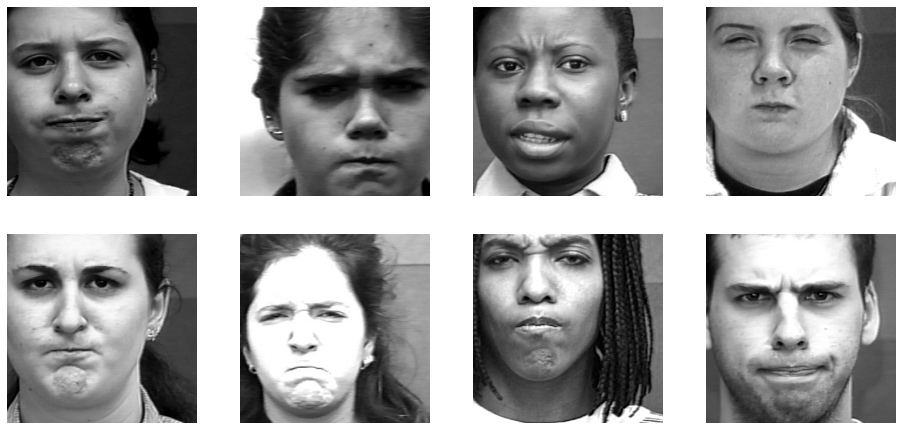

In [3]:
%matplotlib inline
import matplotlib.image as mpimg

#parameters for our graph; we will output images in 4*4 configuration

nrows = 4
ncol = 4
dataD = 'Training_data/Angry'
#index for iterating over images 
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncol*4, nrows * 4)
pic_index += 8
angryFace = os.listdir(dataD)
next_angry_face = [os.path.join(dataD, fname) for fname in os.listdir(dataD)[pic_index -8 : pic_index]]
for i, img_path in enumerate(next_angry_face):
    sp = plt.subplot(nrows, ncol, i + 1)
    sp.axis('Off')
    img = cv.imread(img_path,7)
    plt.imshow(img)

In [6]:
load_weights_file = '/home/nixon/workdir/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = VGG16(input_shape=(224,224,3),
                              include_top = False,
                              weights = None)
pre_trained_model.load_weights(load_weights_file)
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
for layer in pre_trained_model.layers:
        layer.trainable = False

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(2048, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2048, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(7, activation = 'softmax')(x)

dataset = load_data()
train_data = dataset['train_data']
train_labels = dataset['train_labels']
test_data = dataset['test_data']
test_labels = dataset['test_labels']

#model declaration
model = Model(pre_trained_model.input,x)
#print(model.summary())
model.compile(optimizer = 'Adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])
history = model.fit(x = train_data, y = train_labels, epochs=65,verbose = 1, validation_data = (test_data,test_labels))
model.save('VGGSave')

last layer output shape (None, 7, 7, 512)
Epoch 1/65
17/17 [==============================] - 2s 132ms/step - loss: 63.4680 - accuracy: 0.2093 - val_loss: 10.2388 - val_accuracy: 0.1915
Epoch 2/65
17/17 [==============================] - 1s 72ms/step - loss: 15.6898 - accuracy: 0.3198 - val_loss: 4.0248 - val_accuracy: 0.3830
Epoch 3/65
17/17 [==============================] - 1s 72ms/step - loss: 7.2854 - accuracy: 0.3159 - val_loss: 2.0690 - val_accuracy: 0.3617
Epoch 4/65
17/17 [==============================] - 1s 71ms/step - loss: 5.0146 - accuracy: 0.3488 - val_loss: 2.2975 - val_accuracy: 0.2979
Epoch 5/65
17/17 [==============================] - 1s 75ms/step - loss: 3.3241 - accuracy: 0.4031 - val_loss: 1.7863 - val_accuracy: 0.3404
Epoch 6/65
17/17 [==============================] - 1s 71ms/step - loss: 2.6992 - accuracy: 0.3798 - val_loss: 1.8760 - val_accuracy: 0.4468
Epoch 7/65
17/17 [==============================] - 1s 75ms/step - loss: 2.2810 - accuracy: 0.3779 - val_los